# Importar bibliotecas

In [1]:
# Processamento numérico
import numpy as np

# Treinamento/processamento de modelos de IA de aprendizado profundo
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Processamento de imagens
import torchvision
from torchvision import datasets, transforms, models

# Visualização
import matplotlib.pyplot as plt
from PIL import Image

# Configuração de exibição de gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Carregamento dos dados

In [2]:
# Caminho onde estão armazenadas as imagens
data_dir = '../../../mnt/e/Python/Projetos/NASA/Data'

# Preparação e treino

Como as fotos de rochas têm tamanhos diferentes (pequeno, médio e grande), é necessário ajustar o tamanho para que todas fiquem padronizadas (224 × 224 pixels). Dessa forma, o processamento das imagens pela rede neural é facilitado.

In [3]:
# Transformação da imagem
img_transformation = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [4]:
# Função para ler os dados; cortar e redimensionar as imagens
def load_split_train_test(datadir, valid_size=0.2):
    # Carregar os datasets e transformar as imagens
    train_data = datasets.ImageFolder(datadir, transform=img_transformation)
    test_data = datasets.ImageFolder(datadir, transform=img_transformation)

    # Dividir em datasets de treino/teste
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Carregamento dos dados para o modelo
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

In [5]:
# Usar 20% dos dados para teste
trainloader, testloader = load_split_train_test(data_dir, 0.2)
print(trainloader.dataset.classes)

['Basalt', 'Highland']


# Exibição de algumas imagens

In [6]:
# Função para selecionar um grupo de imagens aleatoriamente
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=img_transformation)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

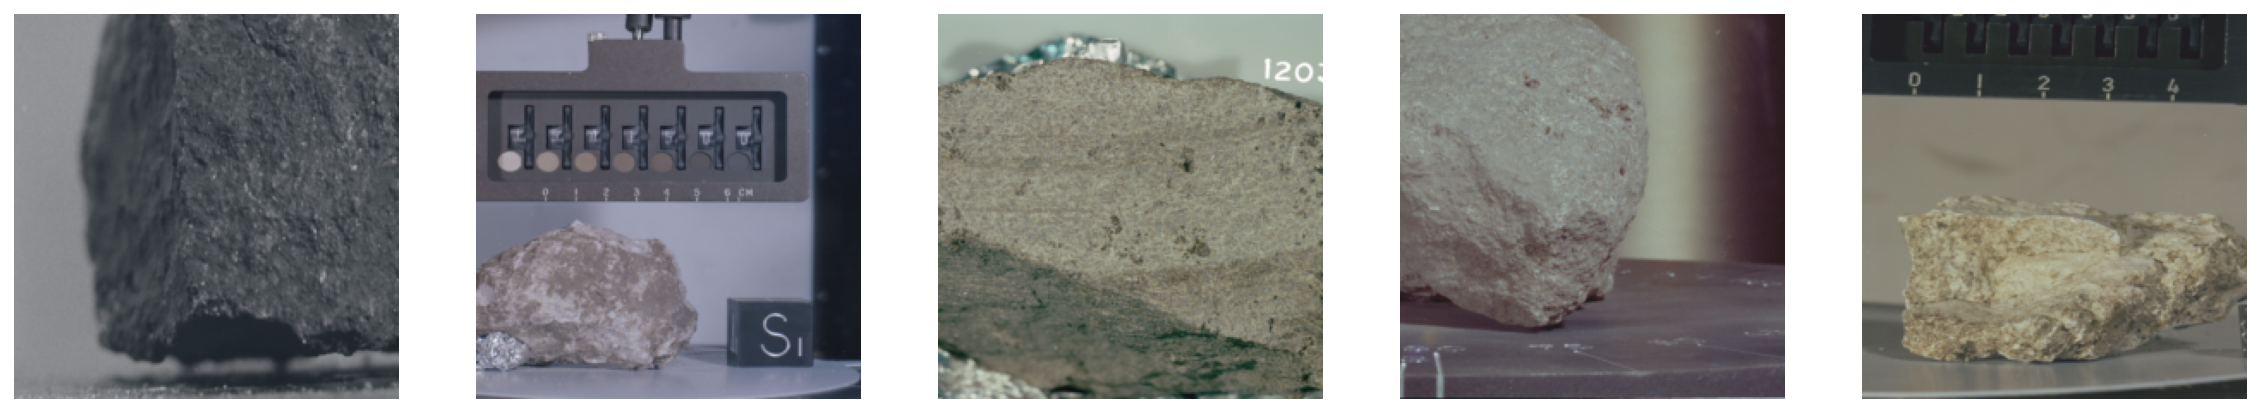

In [7]:
# Exibir as n imagens selecionadas da pasta de origem
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()

# Gerar subplot com as imagens
fig = plt.figure(figsize=(20,20))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [8]:
labels

tensor([0, 1, 0, 0, 1])

# Criar rede neural

In [9]:
# Carregar modelo pré-treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

In [10]:
# Construir camadas de neurônios
for param in model.parameters():
    param.requires_grad = False

# Configurar parâmetros do modelo de deep learning
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


# Treinar a rede neural

In [11]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:

        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 1.650.. Test loss: 2.568.. Test accuracy: 0.519
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/5.. Train loss: 2.191.. Test loss: 1.146.. Test accuracy: 0.548
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 2/5.. Train loss: 0.575.. Test loss: 0.308.. Test accuracy: 0.902
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 3/5.. Train loss: 0.413.. Test loss: 0.342.. Test accuracy: 0.871
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 4/5.. Train loss: 0.344.. Test loss: 0.293.. Test accuracy: 0.902
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 4/5.. Train loss: 0.328.. Test loss: 0.393.. Test accuracy: 0.773
Training step  31
Training step  32
T

In [12]:
print(accuracy/len(testloader))

0.9666666686534882


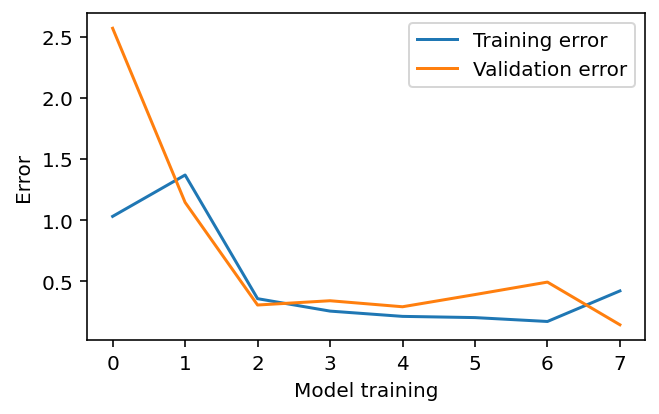

In [13]:
fig = plt.figure(figsize=(5,3))

plt.plot(train_losses, label='Training error')
plt.plot(test_losses, label='Validation error')

plt.legend()
plt.xlabel('Model training'), plt.ylabel('Error')
plt.show()

In [14]:
torch.save(model, 'aerialmodel.pth')

# Carregar e testar a rede neural

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('aerialmodel.pth')

In [18]:
def predict_image(image):
    image_tensor = img_transformation(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

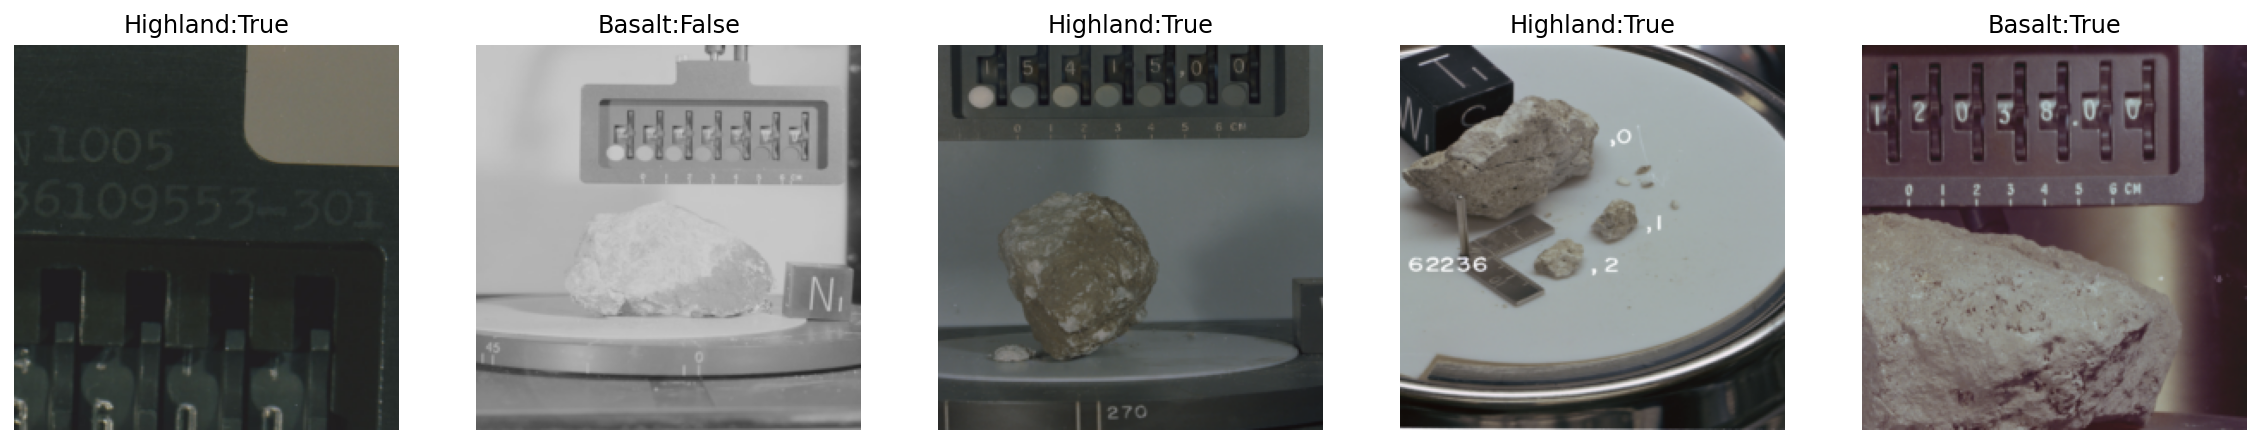

In [20]:
images, labels = get_random_images(5)

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20,10))

classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()